## Driving mechanisms of sea ice breakup - winds    

In [2]:
%matplotlib inline
import sys
import xarray as xr
import datetime as dt
import pandas as pd
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

sys.path.append('../src')
from pynextsim.projection_info import ProjectionInfo
from brkup_utils import lead_detect as lead_det
from brkup_utils import process_data
from brkup_utils import mask_funcs as msk
from brkup_utils import grid_funcs as grd 
from brkup_utils.openerEra5 import OpenerEra5
from brkup_utils.boxnames import *

In [3]:
# read moorings 
indir = '/home/rheinlender/shared-simstore-ns9829k/NANUK/NANUK025-ILBOXE140-S/'    

months = ['01', '02', '03']
years = list(range(2000, 2018+1))
region='Beaufort'

# subset Beaufort Sea
ds = process_data.load_moorings(indir,months,years,region='Beaufort',period=None)

# daily average

# set all dates to have time at 00h so multiple measurements in a day have the same label
ds.coords['time'] = ds.time.dt.floor('1D')
ds = ds.groupby('time').mean()

months: ['01', '02', '03']
years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
bbox for Beaufort : (95, 225, 425, 575)
DONE!


In [4]:
# create masks
bbox = BOXNAMES[region]
Mask = msk.Masking(ds, bbox=bbox)
msk_moore22 = Mask.get_Moore2022_Beaufort_mask()

# get area info from model grid and add to dataset
creg_grid = grd.CREGgrid('../grid_files', bbox)
ds['mod_area'] = (('y','x'), creg_grid.get_area())
ds['mod_area'].attrs = {'units':'m2', 'long_name':'grid_cell_area'}


## Get winds from daily ERA5 data

In [5]:

# Load daily ERA5 data
varname=['u10', 'v10', 'msl']
year0 = 2000
year1 = 2018

era_file = []
for var in varname:
    # create the opener
    op = OpenerEra5(var)

    for year in range(year0, year1+1):

        # get the file name
        dto = dt.datetime(year,1,1)
        era_file.append(op.find(dto))

ds_era5 = xr.open_mfdataset(era_file, parallel=True, engine='netcdf4',chunks={'time':-1,'y': 300, 'x':250})

# get lon/lat
lat_e = ds_era5.latitude.values
lon_e = ds_era5.longitude.values
    
# get winter months from daily data
months=[1,2,3]
#ds_era5 = ds_era5.sel(time = np.in1d(ds['time.month'], months), drop=True)

#-- Extract transect from 70-75N along 150W
ds_slice = ds_era5.sel(time = np.in1d(ds_era5['time.month'], months), 
                       longitude=360-150, 
                       latitude=slice(75,70), 
                       drop=True)
u = ds_slice.u10
v = ds_slice.v10

#-- Compute the wind speed (magnitude)
wind_speed = np.sqrt(u**2 + v**2)

#-- SLP difference between 75N and 70N 
slp_diff = (ds_slice.msl.sel(latitude=75) -  ds_slice.msl.sel(latitude=70)) *1E-2 # hPa

# -- compute averages
wind_speedavg = np.mean(wind_speed, axis=(-1))
wind_speedmax = np.max(wind_speed, axis=(-1))

slp_diffmean = slp_diff.groupby('time.year').mean('time') # 2000-2018 mean (JFM)
slp_diffstd = slp_diff.groupby('time.year').std('time')   # 2000-2018 standard deviation (JFM)

upper_lim = slp_diffmean.values + slp_diffstd.values      # mean+1STD


## Duration of strong winds (>8.5 m/s)

Calculates the number of days during the winter season where the **daily** wind exceeds a threshold of 8.5 m/s (roughly one STD above the mean)   

In [6]:
## Duration (in days) with strong winds

var = wind_speedavg
_mean = var.mean(axis=0).values # climatology of JFM-mean values
_std = var.std(axis=0).values # standard deviation of JFM values

#wind_thrshold = 8
wind_thrshold = _mean + _std

print("Wind sthreshold:", wind_thrshold, "m/s")

n_days = []
for yr in range(2000, 2019):
    sel=wind_speedavg.sel(time=str(yr))
    ndaysum = xr.where(sel>wind_thrshold, 1, 0).sum('time').values
    n_days.append(ndaysum)

years = wind_speedavg.groupby('time.year').mean('time').year
wind_duration = xr.DataArray(n_days,
                             coords={'time': years}, 
                             dims=["year"])


Wind sthreshold: 8.503173 m/s


## Beaufort lead fraction

In [7]:
# Calculate lead area fraction
clim=0.05
leadfrac, leadmask = lead_det.map_leads(ds, 'breakup_paper', clim)
    
# daily lead area frac in Beaufort Sea
lfa = leadmask.where(msk_moore22).mean(dim=('x', 'y'))

#lfa_daily = lfa.groupby('time.date').mean()

lfa_JFM = lfa.groupby('time.year').mean('time')

# Normalized lead fraction
lfa_JFMmean = lfa_JFM.mean('year')
lfa_JFMstd = lfa_JFM.std('year')
lfa_JFMnorm = (lfa_JFM - lfa_JFMmean)/ lfa_JFMstd

print("JFM-average LAF:", lfa_JFMmean.values)
print("JFM standard deviation LAF:", lfa_JFMstd.values)

JFM-average LAF: 0.1945887053449649
JFM standard deviation LAF: 0.036829880268745806


# Winds

/opt/conda/envs/pynextsim/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


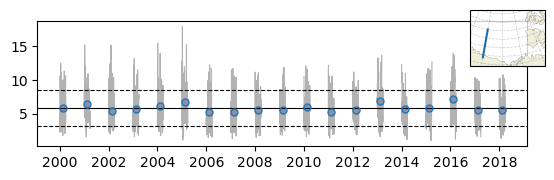

In [8]:
def plot_daily_winds(ax, plotvar):
    
    import cartopy
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.geoaxes import GeoAxes
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    start_date = dt.datetime.strptime("2000-02-15", "%Y-%m-%d")
    date_list = pd.date_range(start_date, periods=19, freq=pd.DateOffset(years=1))

    _mean = plotvar.mean(axis=0).values # climatology of JFM-mean values
    _std = plotvar.std(axis=0).values # standard deviation of JFM values

    plot_crs = ccrs.NorthPolarStereo(central_longitude=-140, true_scale_latitude=60)

    for y in range(2000,2019):
        tmp = plotvar.sel(time=str(y), drop=True)
        ax.plot(tmp.time, tmp, color='black', alpha=0.3, lw=0.8)

    ax.axhline(y=_mean, ls='-', color='black', alpha=1, lw=0.8, zorder=1)
    ax.axhline(y=_mean - _std, ls='--', color='black', alpha=1, lw=0.8, zorder=1)
    ax.axhline(y=_mean + _std, ls='--', color='black', alpha=1, lw=0.8, zorder=1)

    y = plotvar.groupby('time.year').mean('time') # JFM-mean
    h1 = ax.plot(date_list, y, ls='None', marker='o', markersize=5, markeredgecolor='C0', markerfacecolor=(0,0,0.5,.2))
    #ax.legend()

    # Inset map
    axins = inset_axes(ax, width="45%", height="45%", loc="lower left", 
                       axes_class=GeoAxes, 
                       axes_kwargs=dict(map_projection=plot_crs),
                       bbox_to_anchor=(0.72,0.58,1,1), bbox_transform=ax.transAxes)

    axins.set_extent([-155, -120, 68, 78], ccrs.PlateCarree())
    axins.add_feature(cfeature.LAND, facecolor=cfeature.COLORS['land'], zorder=1)
    axins.coastlines(resolution="50m",linewidth=0.1)
    gl = axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='black', linestyle='--', alpha=0.2)   

    axins.plot([-150, -150], [70, 75], transform=ccrs.PlateCarree())
    axins.patch.set_alpha(0.8)

    return fig, ax

# testing
fig = plt.figure(figsize=(5,8), constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=1, left=0.01, right=0.99, wspace=0.3, hspace=0.3)
ax2 = fig.add_subplot(gs[1,:])
plot_daily_winds(ax2, wind_speedavg)
fig.savefig('../figures/' + f'fig04a_meanWspeed_daily_150W70-75N_2000-2018.png', dpi=300, bbox_inches='tight')


# Plot Figure 4

/opt/conda/envs/pynextsim/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


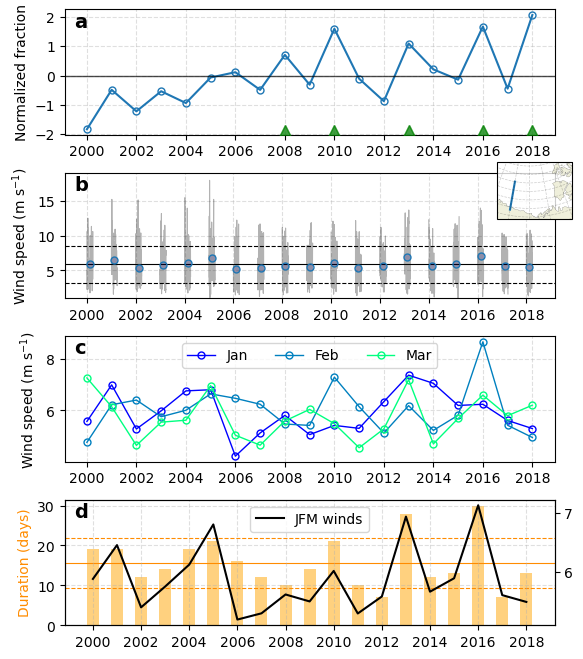

In [9]:

fig = plt.figure(figsize=(5,8), constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=1, left=0.01, right=0.99, wspace=0.3, hspace=0.3)

kw={'alpha': 1, 'linewidth':1, 'marker':'o', 'markersize':5, 'markeredgecolor':'C0'}
kw1={'alpha': 1, 'linewidth':1.5, 'marker':'o', 'markersize':5, 'markerfacecolor':'None'}
kw2={'alpha': 1, 'linewidth':1, 'marker':'o', 'markersize':5, 'markerfacecolor':'None'}


x = wind_speedavg.groupby('time.year').mean('time').year
cmap = plt.cm.winter(np.linspace(0,1,3))

#####1 normalized lead fraction
ax1 = fig.add_subplot(gs[0,:])
ax1.set_ylabel('Normalized fraction');
ax1.plot(x, lfa_JFMnorm, **kw1)
ax1.axhline(y=0, lw=1, color='k', alpha=.7)
ax1.set_yticks([-2, -1, 0, 1, 2])
ax1.set_xticks(np.arange(2000,2018+2,2));

#####2 daily winds
ax2 = fig.add_subplot(gs[1,:])
plot_daily_winds(ax2, wind_speedavg)
ax2.set_ylim([1, 19])
ax2.set_ylabel('Wind speed (m s$^{-1}$)')


#####3 monthly winds 
ax3 = fig.add_subplot(gs[2,:])
ax3.set_ylabel('Wind speed (m s$^{-1}$)');
ax3.set_xticks(np.arange(2000,2018+2,2));

wspeed_mean_monthly = process_data.monthly_mean_by_year(wind_speedavg)

ax3.plot(x, wspeed_mean_monthly.sel(time_level_1=1), label='Jan', **kw2, color=cmap[0])
ax3.plot(x, wspeed_mean_monthly.sel(time_level_1=2), label='Feb', **kw2, color=cmap[1])
ax3.plot(x, wspeed_mean_monthly.sel(time_level_1=3), label='Mar', **kw2, color=cmap[2])
ax3.legend(ncol=3, loc='upper center')
                
#####4 duration of strong winds
ax4 = fig.add_subplot(gs[3,:])
ax4.set_ylabel('Duration (days)', color='darkorange')
ax4.set_xticks(np.arange(2000,2018+2,2));

_mean = wind_duration.mean()
_std = wind_duration.std()

ax4.bar(x, wind_duration, width=0.5, alpha=0.5, color='orange', zorder=0)
ax4.axhline(y=_mean, ls='-', color='darkorange', alpha=1, lw=0.8, zorder=1)
ax4.axhline(y=_mean - _std, ls='--', color='darkorange', alpha=1, lw=0.8, zorder=1)
ax4.axhline(y=_mean + _std, ls='--', color='darkorange', alpha=1, lw=0.8, zorder=1)

##-add plot of JFM-mean winds
add_ax = ax4.twinx()
add_ax.plot(x, wind_speedavg.groupby('time.year').mean('time'), color='black', lw=1.5, zorder=10, label='JFM winds') #JFM mean 
add_ax.legend(loc='upper center')

# add figure labels
axes = (ax1,ax2,ax3,ax4)
labels = ['a', 'b', 'c', 'd']
for ax, lab in zip(axes, labels):
    ax.text(0.02, 0.98, lab, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top')
    ax.grid(ls='--', alpha=0.4)
  #  ax.set_xticks(np.arange(2000,2018+3,3));

# highlight breakup years
id_yrs = x[x.year.isin([2008, 2010, 2013, 2016, 2018])]
cbargs = {'color': 'green', 'alpha': 0.5, 'zorder':3, 'marker':"^", 'markersize': 15, 'ymax':0.}
[ax1.axvline(dto, **cbargs) for dto in id_yrs]

fig.savefig('../figures/' + f'fig04_leadFrac_meanWspeed_150W70-75N_2000-2018.png', dpi=300, bbox_inches='tight')
